# Homework 1: Text Mining
## Part 2: Text analysis

Group Members: Matias Borrel, Pol Garcia, Marvin Ernst

#### Importing relevant Libraries:

In [166]:
import os
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
import unidecode
from textblob import TextBlob  # For sentiment analysis - we have seen this in our statistics course already, when we had to analyze hotel reviews for homework 3 last term.

[nltk_data] Downloading package stopwords to /Users/Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/Admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Define file paths:

In [167]:
files = {
    "Barcelona": {
        "During": "./Original_data/hotels_barcelona_MWC.csv",
        "Post": "./Original_data/hotels_barcelona_after_MWC.csv",
    },
    "Madrid": {
        "During": "./Original_data/hotels_madrid_MWC.csv",
        "Post": "./Original_data/hotels_madrid_after_MWC.csv",
    },
}

#### Load Data:

In [168]:
dataframes = {city: {key: pd.read_csv(path) for key, path in city_files.items()} for city, city_files in files.items()}

#### Inspect the data frames:

Print column names for each dataframe:

In [169]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"{city} - {period}:")
        print(df.columns)
        print("\n")

Barcelona - During:
Index(['Name', 'Price', 'Rating', 'Detail Link', 'Description'], dtype='object')


Barcelona - Post:
Index(['Name', 'Price', 'Rating', 'Detail Link', 'Description'], dtype='object')


Madrid - During:
Index(['Name', 'Price', 'Rating', 'Detail Link', 'Description'], dtype='object')


Madrid - Post:
Index(['Name', 'Price', 'Rating', 'Detail Link', 'Description'], dtype='object')




#### Preparing the Dataframes

We want that during and post treatment we have the same units (here "hotels") in each of the groups (here "city"). 

Filter Out Rows with Empty Names, or missing values for any of the columns:

In [170]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Drop rows with missing values in any column
        dataframes[city][period] = df.dropna(how='any')

Retain Only Names Present in Both During and Post:

In [171]:
for city, periods in dataframes.items():
    # Get the intersection of names in During and Post datasets
    common_names = set(periods['During']['Name']).intersection(set(periods['Post']['Name']))
    
    # Filter rows in both During and Post to only include these common names
    dataframes[city]['During'] = periods['During'][periods['During']['Name'].isin(common_names)]
    dataframes[city]['Post'] = periods['Post'][periods['Post']['Name'].isin(common_names)]

Verify Results:

In [172]:
for city, periods in dataframes.items():
    print(f"{city} - During dataset shape: {periods['During'].shape}")
    print(f"{city} - Post dataset shape: {periods['Post'].shape}")
    print(f"{city} - Common Names: {len(set(periods['During']['Name']).intersection(set(periods['Post']['Name'])))}")

Barcelona - During dataset shape: (390, 5)
Barcelona - Post dataset shape: (390, 5)
Barcelona - Common Names: 390
Madrid - During dataset shape: (511, 5)
Madrid - Post dataset shape: (511, 5)
Madrid - Common Names: 511


Check for duplicates:

In [173]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Check for duplicates in the 'Name' column
        duplicate_count = df['Name'].duplicated().sum()  # Count duplicates
        total_names = df['Name'].shape[0]  # Total number of rows
        print(f"{city} - {period}:")
        print(f"Total Names: {total_names}, Duplicates: {duplicate_count}")
        
        if duplicate_count > 0:
            # Display duplicate rows
            duplicates = df[df['Name'].duplicated(keep=False)]
            print("Duplicate Names:")
            print(duplicates[['Name']])
        print("\n")

Barcelona - During:
Total Names: 390, Duplicates: 0


Barcelona - Post:
Total Names: 390, Duplicates: 0


Madrid - During:
Total Names: 511, Duplicates: 0


Madrid - Post:
Total Names: 511, Duplicates: 0




Since we do not have any dublicates, we don't need to further filter some observations, i.e. the names uniquely identify each hotel.

#### Convert the Price to numeric:

In [174]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Remove all non-numeric characters (e.g., € and spaces) and dots (thousands separators)
        df['Price'] = (
            df['Price']
            .astype(str)  # Ensure the column is treated as strings
            .str.replace(r'[^\d]', '', regex=True)  # Remove non-numeric characters
            .astype(int)  # Convert cleaned strings to integers
        )

Verify the changes:

In [175]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"--- {city} - {period} ---")
        print(df[['Name', 'Price']].head())  # Show the 'Name' and cleaned 'Price' columns
        print("\n")

--- Barcelona - During ---
                                     Name  Price
0                 chic&basic Habana Hoose   2652
1  Axel TWO Barcelona 4 Sup - Adults Only   2149
2      Barcelonaforrent The Central Place   5312
3                         Tembo Barcelona   2840
4          Hesperia Barcelona Barri Gòtic   2327


--- Barcelona - Post ---
                             Name  Price
0         chic&basic Habana Hoose   1075
4                    Hotel Market    807
5   Travelodge Barcelona Poblenou    651
10                  Hotel Condado    696
11  BCN Urbaness Hotels Bonavista    725


--- Madrid - During ---
                                  Name  Price
0                      Room Mate Oscar    996
1                     Sonder Santa Ana   1219
2                       Hostal Mendoza    584
4  Amor de Dios 17 Boutique Apartments    780
6                  Hostal Flat55Madrid    545


--- Madrid - Post ---
                      Name  Price
0      Hostal Flat55Madrid    487
1         So

##### Deleting the Link column:

In [176]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Drop the 'Detail Link' column if it exists
        if 'Detail Link' in df.columns:
            df.drop(columns=['Detail Link'], inplace=True)

#### Convert the Ranking to numeric:

In [177]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        if 'Rating' in df.columns:
            # Extract numeric values, replace commas with dots, and convert to float
            df['Rating'] = (
                df['Rating']
                .astype(str)  # Ensure all values are strings
                .str.extract(r'(\d+,\d+)')  # Extract only the first valid number
                .replace(',', '.', regex=True)  # Replace comma with dot
                .astype(float)  # Convert to float
            )

Verify the changes:

In [178]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"--- {city} - {period} ---")
        print(df[['Name', 'Rating']].head())  
        print("\n")

--- Barcelona - During ---
                                     Name  Rating
0                 chic&basic Habana Hoose    8.58
1  Axel TWO Barcelona 4 Sup - Adults Only    8.38
2      Barcelonaforrent The Central Place    8.28
3                         Tembo Barcelona    8.88
4          Hesperia Barcelona Barri Gòtic    8.78


--- Barcelona - Post ---
                             Name  Rating
0         chic&basic Habana Hoose    8.58
4                    Hotel Market    7.67
5   Travelodge Barcelona Poblenou    7.37
10                  Hotel Condado    8.58
11  BCN Urbaness Hotels Bonavista    7.87


--- Madrid - During ---
                                  Name  Rating
0                      Room Mate Oscar    8.78
1                     Sonder Santa Ana    8.68
2                       Hostal Mendoza    7.97
4  Amor de Dios 17 Boutique Apartments    7.87
6                  Hostal Flat55Madrid    8.08


--- Madrid - Post ---
                      Name  Rating
0      Hostal Flat55Madrid 

#### Summarize and Compare:

In [179]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        avg_price = round(df['Price'].mean(), 2)  # Round average price to 2 decimal places
        avg_score = round(df['Rating'].mean(), 2)  # Round average score to 2 decimal places
        print(f"{city} - {period}: Avg Price = {avg_price}, Avg Score = {avg_score}")

Barcelona - During: Avg Price = 2607.06, Avg Score = 8.3
Barcelona - Post: Avg Price = 1193.16, Avg Score = 8.3
Madrid - During: Avg Price = 1231.2, Avg Score = 7.76
Madrid - Post: Avg Price = 1293.38, Avg Score = 7.76


As expected, the rankings are the same, and we see changes in the price.

## (a) Preprocess the Text 

##### Looking at the first few descriptions:

In [180]:
pd.set_option('display.max_colwidth', None) # to see the full descriptions

for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"--- {city} - {period} ---")
        print(df[['Name', 'Description']].head())  
        print("\n")

--- Barcelona - During ---
                                     Name  \
0                 chic&basic Habana Hoose   
1  Axel TWO Barcelona 4 Sup - Adults Only   
2      Barcelonaforrent The Central Place   
3                         Tembo Barcelona   
4          Hesperia Barcelona Barri Gòtic   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

##### Check whether descriptions match for both observation times:

In [181]:
for city, periods in dataframes.items():
    # Merge the During and During dataframes on 'Name'
    merged_df = periods['During'].merge(periods['Post'], on='Name', suffixes=('_During', '_Post'))
    
    mismatched = merged_df[merged_df['Description_During'] != merged_df['Description_Post']]
    
    print(f"--- {city}: Description Differences ---")
    if mismatched.empty:
        print("All descriptions match!")
    else:
        print(mismatched[['Name', 'Description_During', 'Description_Post']])
    print("\n")

--- Barcelona: Description Differences ---
All descriptions match!


--- Madrid: Description Differences ---
                                          Name Description_During  \
484       Mini Apartamento EL SOTANO de ATOCHA              Error   
485         La Latina Hub Perfect Location MAD              Error   
486  JACUZZI FULL exterior SOL, by MONARO*****              Error   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

#### Generate a dataframe for all four observations:

In [182]:
final_data = []

for city, periods in dataframes.items():
    merged_df = periods['During'].merge(periods['Post'], on='Name', suffixes=('_During', '_Post'))
    
    merged_df['Barcelona'] = 1 if city == "Barcelona" else 0

    # During_Treatment = 1 for "During" period (event happening), 0 for "Post" period (no treatment)
    selected_columns_during = merged_df[['Name', 'Barcelona', 'Price_During', 'Rating_During', 'Description_During']].copy()
    selected_columns_during['During_Treatment'] = 1  

    selected_columns_post = merged_df[['Name', 'Barcelona', 'Price_Post', 'Rating_During', 'Description_During']].copy()
    selected_columns_post['During_Treatment'] = 0  

    selected_columns_during.rename(columns={'Price_During': 'Price', 'Rating_During': 'Rating', 'Description_During': 'Description'}, inplace=True)
    selected_columns_post.rename(columns={'Price_Post': 'Price', 'Rating_During': 'Rating', 'Description_During': 'Description'}, inplace=True)

    final_data.append(selected_columns_during)
    final_data.append(selected_columns_post)

final_df = pd.concat(final_data, ignore_index=True)

#### Normalize and Remove Special Characters:

In [183]:
final_df['Description'] = final_df['Description'].str.replace(r'[√©√±]', '', regex=True)

#### Tokenize, Remove Stop Words, and Stem:

We use Spanish Snowball Stemmer for better accuracy:

In [184]:
stemmer = SnowballStemmer("spanish")

Spanish stopwords and city names to remove:

In [185]:
stop_words = set(stopwords.words("spanish")) | {"barcelona", "madrid", "hotel"}

Regex pattern to detect numbers followed by distance or time units:

In [186]:
distance_pattern = re.compile(r"(\d+)\s+(km|kilometros|metros|millas|yardas|m|ft|feet|yd)", re.IGNORECASE)
time_pattern = re.compile(r"(\d+)\s+(minuto|minutos|hora|horas)", re.IGNORECASE)

We believe lemmatization (instead of stemming) for better Spanish text processing.

In [187]:
def preprocess_text(text):
    if pd.isna(text):
        return ""  # Handle NaN values

    text = text.lower()  # Convert to lowercase

    # Preserve numbers with distance/time expressions as a single token
    text = distance_pattern.sub(lambda x: f"{x.group(1)}_{x.group(2)}", text)
    text = time_pattern.sub(lambda x: f"{x.group(1)}_{x.group(2)}", text)

    # Remove accents, punctuation, and standalone numbers (except for preserved ones)
    text = unidecode.unidecode(text)  # Remove accents (á -> a, ñ -> n)
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\b\d+\b", "", text)  # Remove standalone numbers

    # Tokenization and Stemming
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return " ".join(stemmed_tokens)

# Apply preprocessing to the dataset
final_df['Cleaned_Description'] = final_df['Description'].astype(str).apply(preprocess_text)

## (b) Create Word Clouds:

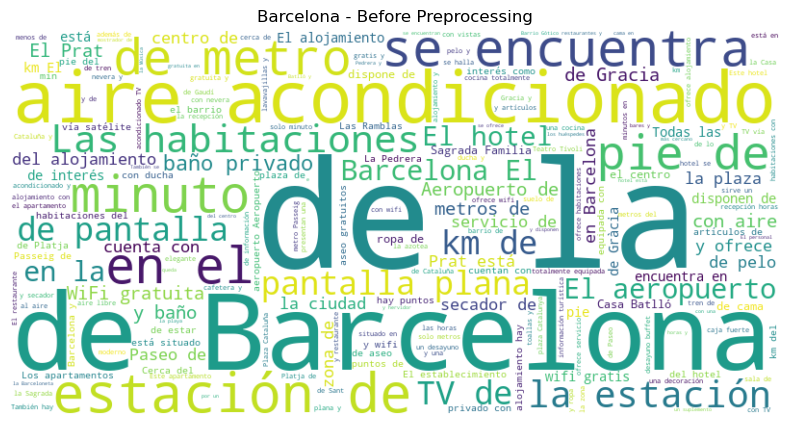

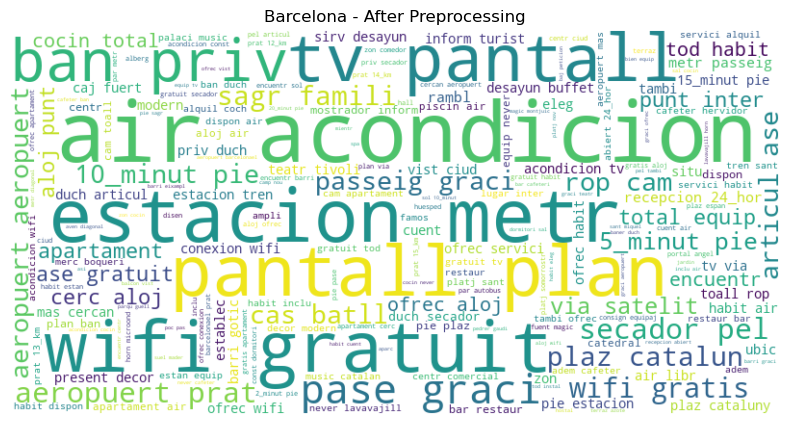

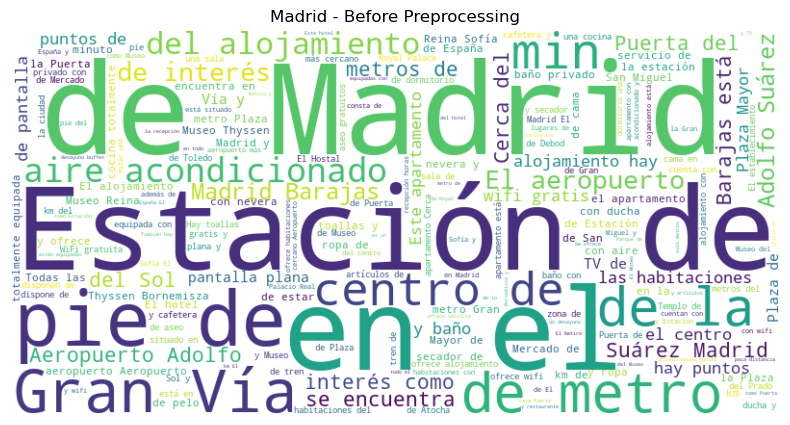

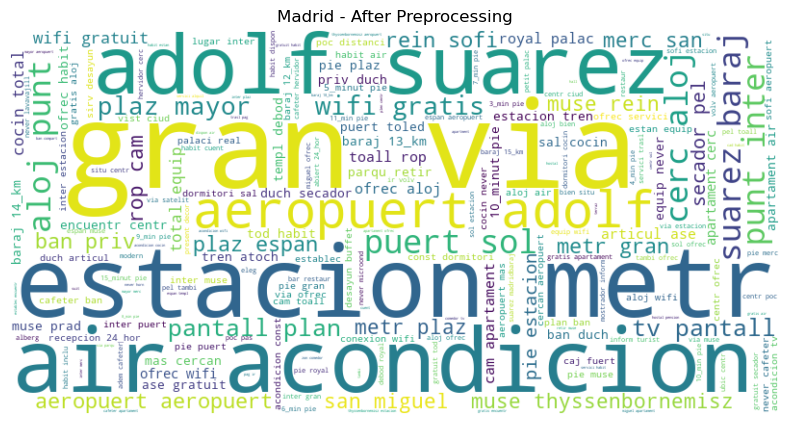

In [188]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each city before and after preprocessing
for city_label, city_name in [(1, "Barcelona"), (0, "Madrid")]:
    city_df = final_df[final_df['Barcelona'] == city_label]
    
    # Raw descriptions
    generate_wordcloud(city_df['Description'].dropna(), f"{city_name} - Before Preprocessing")

    # Cleaned descriptions
    generate_wordcloud(city_df['Cleaned_Description'].dropna(), f"{city_name} - After Preprocessing")

We can see that the words have improved a lot and now show words that seem to be more important for an analysis such as "air acondicion" or "wifi" compared to just the name of the city or "de la".

## Extracting Metadata:

In [189]:
special_words = ["centro", "playa", "aeropuerto", "wifi", "metro", "piscina", "habitacion"]

def extract_metadata(text):
    if pd.isna(text) or text.strip() == "":
        return pd.Series([0, 0, 0, 0, 0])  # Handle empty cases

    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    
    # Compute metadata features
    word_count = len(words)
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / max(1, word_count)  # Avoid division by zero
    sentiment_score = TextBlob(text).sentiment.polarity  # Sentiment polarity

    # Count occurrences of special words
    special_mentions = sum(text.count(word) for word in special_words)

    return pd.Series([word_count, sentence_count, avg_word_length, special_mentions, sentiment_score])

# Apply function to create metadata columns
final_df[["Word_Count", "Sentence_Count", "Avg_Word_Length", "Special_Mentions", "Sentiment_Score"]] = \
    final_df["Cleaned_Description"].apply(extract_metadata)

####  Save Cleaned Data:

In [190]:
final_df.to_csv("final_cleaned_data.csv", index=False)